In [3]:
import jax.numpy as np
import jax.random as jr

from importlib import reload
from vmfg_etc import VonMisesFisherGaussian
from vmfg_etc import hvmfg

from vmfg_etc import util

import tensorflow_probability.substrates.jax.distributions as tfd

import matplotlib.pyplot as plt


# Generate synthetic data

In [4]:
seed = jr.PRNGKey(1654)

seed_ = iter(jr.split(seed, 10))

K = 5
D = 2

seed_par = next(seed_)
parents = np.array(
    [jr.randint(jr.fold_in(seed_par, k), (), 0, k, int)
    for k in range(K)]
)
# Root distribution could be anywhere...good for inference
# root_distr = tfd.MultivariateNormalDiag(np.zeros(D), scale_identity_multiplier=1e3)
root_distr = tfd.MultivariateNormalDiag(np.zeros(D), scale_identity_multiplier=1e-3)

sample_shape = (K-1,D)
mean_direction = jr.normal(next(seed_), sample_shape)
mean_direction /= np.linalg.norm(mean_direction, axis=-1, keepdims=True)

# Non-negative values
concentration = jr.normal(next(seed_,), sample_shape[:-1]) * 10 + 50
concentration = np.maximum(concentration, 5)

scale = jr.uniform(next(seed_), sample_shape[:-1], minval=1e-2, maxval=2)
radii = jr.randint(next(seed_), sample_shape[:-1], 1, 6)

leaf_distr = VonMisesFisherGaussian(mean_direction, concentration, scale, radii)


In [8]:
reload(hvmfg)
HierarchicalVonMisesFisherGaussian = hvmfg.HierarchicalVonMisesFisherGaussian

# ----------------------------------------------------------------------------

hvmfg = HierarchicalVonMisesFisherGaussian(parents, root_distr, leaf_distr)
samples = hvmfg.sample((500,), jr.PRNGKey(349))
print(samples.shape)

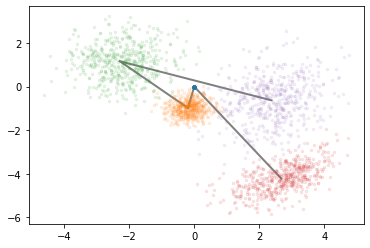

In [11]:
def modal_skeleton_config(hvmfg, ax, **kwargs):
    """Draw modal skeleton configuration for 2D h-vMFG distribution.

    Params
        hvmfg: tfd.Distribution
            2D Hierarchical von Mises-Fisher Gaussian distribution
        ax: matplotlib.ax.Axes
        kwargs:
            Additional keywords to pass into plt.plot
    """
    
    assert hvmfg.event_shape[-1] == 2
    modal_pos = hvmfg.mode()

    for k in range(1, K):
        par = hvmfg.parents[k]
        
        ln = np.concatenate([modal_pos[...,[par],:], modal_pos[...,[k],:]], axis=-2)
        ax.plot(ln[...,0], ln[...,1], **kwargs)
    return

# ----------------------------------------------------------------------------
# Plot sampled node locations, colored by identity, and skeleton of modal config
for k in range(K):
    color = f'C{k}'
    plt.scatter(samples[...,k,0], samples[...,k,1], s=6, c=color, alpha=0.1, zorder=3)

modal_skeleton_config(hvmfg, plt.gca(), lw=2, c='0.5', zorder=1)